# Task 3

In [1]:
using Plots
using BitBasis
using StatsBase

In [2]:
using Yao
using Yao.ConstGate # needed for P1 = 0.5*(I - sigma_z) block

#=
H(t) = Ω(t) ∑_i σ_i^x - δ(t) ∑_i n_i + u ∑_ij n_i n_j
=#

const u = 1.35
const Ω_max = 1.89
const δ_0 = -1.0
const δ_max = 1.0

function get_edges(graph::Vector{NTuple{2, Float64}})
    Nv = size(graph)[1]
    edges = falses(Nv, Nv)
    for i in 1:(Nv-1)
        xi, yi = graph[i]
        for j in (i+1):Nv
            xj, yj = graph[j]

            dij = sqrt((xi - xj)^2. + (yi - yj)^2.)
            if dij <= 1.0
                edges[i,j] = true
            end
        end
    end
    return findall(edges)
end

function Ω(t::Float64)
    if 0 <= t <= 0.25
        return (Ω_max / 0.25) * t
    elseif 0.25 < t <= 0.69
        return Ω_max
    elseif 0.69 < t <= 1
        return - Ω_max * t / 0.31 + Ω_max * (1 + 0.69/0.31)
    end
end

function δ(t::Float64)
    slope = (δ_0 - δ_max)/(0.25 - 0.69)
    if 0 <= t <= 0.25
        return δ_0
    elseif 0.25 < t <= 0.69
        return t * slope + (δ_max - slope * 0.69)
    elseif 0.69 < t <= 1
        return δ_max
    end
end 

function hamiltonian(graph::Vector{NTuple{2, Float64}}, edges::Vector{CartesianIndex{2}}, t::Float64)
    # the UD-MIS Hamiltonian
    Nv = size(graph)[1] # number of vertices

    interaction_term = map(1:size(edges)[1]) do i
        l,m = edges[i][1], edges[i][2]
        repeat(Nv,u*P1,(l,m))
    end |> sum
    interaction_term - δ(t)*sum(map(i->put(Nv,i=>P1), 1:Nv)) + Ω(t)*sum(map(i->put(Nv,i=>X), 1:Nv))
end

function run_annealing(graph::Vector{NTuple{2, Float64}}, edges::Vector{CartesianIndex{2}}, dt::Float64)
    psi_t = zero_state(size(graph)[1])
    for t in 0:dt:1.0
        h = hamiltonian(graph, edges, t)
        psi_t = psi_t |> TimeEvolution(h, dt * 100)
    end
    return psi_t
end

graph = [(1.19,  4.25), 
         (2.71,  3.48), 
         (1.19,  3.51), 
         (2.0,  3.38), 
         (1.12,  2.86), 
         (1.70,  2.42),
         (2.36,  2.54),
         (1.52,  1.48),
         (2.15,  1.54),
         (2.14,  1.87),
         (1.72,  0.86),
         (2.29,  0.87)
        ]
edges = get_edges(graph)
dt = 0.001

psi = run_annealing(graph, edges, dt)
open("task2_data.dat","w") do io
    for sample in measure(psi; nshots=10_000)
        println(io, sample)
    end
end

samples = measure(psi; nshots=10000)
#@show samples

┌ Info: Precompiling Yao [5872b779-8223-5990-8dd0-5abbb0748c8c]
└ @ Base loading.jl:1317


10000-element Vector{BitStr64{12}}:
 010001010011 ₍₂₎
 011000011001 ₍₂₎
 101000010001 ₍₂₎
 100001010011 ₍₂₎
 010000101001 ₍₂₎
 100001010001 ₍₂₎
 011000011001 ₍₂₎
 010001010011 ₍₂₎
 000011010011 ₍₂₎
 100001010011 ₍₂₎
 011000011001 ₍₂₎
 100001010011 ₍₂₎
 010001010011 ₍₂₎
                ⋮
 010001010011 ₍₂₎
 000011010011 ₍₂₎
 010001010011 ₍₂₎
 000011010011 ₍₂₎
 011000010011 ₍₂₎
 100001010011 ₍₂₎
 100001010011 ₍₂₎
 100001010011 ₍₂₎
 101000010011 ₍₂₎
 010001010011 ₍₂₎
 101000010011 ₍₂₎
 100001010011 ₍₂₎

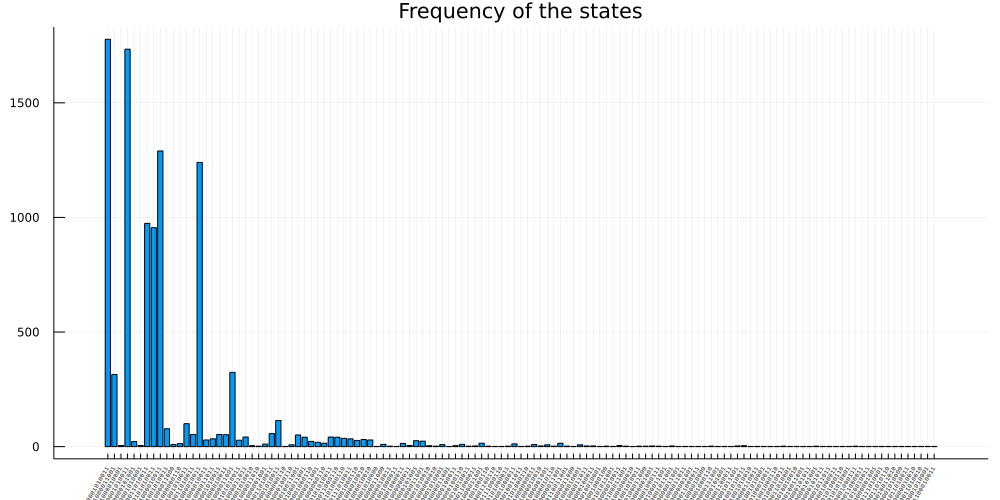

In [3]:
using Plots;
samples_int = [Int(b) for b in samples]
bins_int = unique(samples_int)
s = [string(each, base=2, pad=size(graph)[1]) for each in bins_int]

datamap = countmap(samples)
bins = unique(samples)
b_plot = bar((x -> datamap[x]).(bins),
    xticks=(1:size(s)[1],s),legend=false, xrotation=60,
    xtickfont = font(3, "Courier"),title="Frequency of the states")
Plots.plot!(size=(1000,500))

In [4]:
# get the optimal string (simply as the max)
optimal_sol = findmax(datamap)

(1777, 010001010011 ₍₂₎)

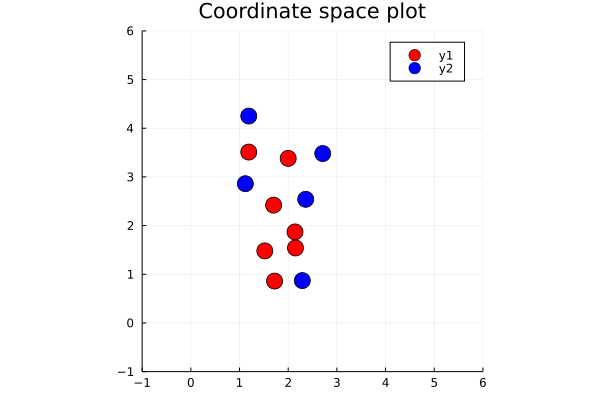

In [6]:
using Plots;

samples_int = [Int(b) for b in samples]
bins_int = unique(samples_int)
s = [string(each, base=2, pad=size(graph)[1]) for each in bins_int]

datamap = countmap(samples)
bins = unique(samples)
b_plot = bar((x -> datamap[x]).(bins),
    xticks=(1:size(s)[1],s),
    xtickfont = font(3, "Courier"))

#savefig(b_plot, "./Week2_Rydberg_Atoms/Graphics/histogram_solutions.svg")

# get the optimal string (simply as the max)
optimal_sol = findmax(datamap)

# plot graph solution
const G = zeros(size(graph)[1],size(graph)[1])

for i=1:size(edges)[1]
    G[edges[i][1],edges[i][2]] = 1
end

g_plot = graphplot(G,
          markersize = 0.3,
          fontsize = 10,
          linecolor = :darkgrey
          )

#savefig(g_plot, "./Week2_Rydberg_Atoms/Graphics/graph_plot.svg")

# plot graph in the coordinate space
bitstr_optim = optimal_sol[2]

red_graph = [graph[i] for i in 1:bit_length(bitstr_optim) if bitstr_optim[i]==0]
blue_graph = [graph[i] for i in 1:bit_length(bitstr_optim) if bitstr_optim[i]==1]

x = [x[1] for x in graph]
y = [x[2] for x in graph]

markerunit = 9 #17 #9 # empirically found
coord_plot = Plots.plot(x, y, seriestype = :scatter,
    title="Coordinate space plot",
    markersize=markerunit,
    xlims=(-1,4),
    ylims=(-1,4),
    aspect_ratio=:equal)

#savefig(coord_plot, "./Week2_Rydberg_Atoms/Graphics/coordinate_plot.svg")

x_red = [x[1] for x in red_graph]
y_red = [x[2] for x in red_graph]
x_blue = [x[1] for x in blue_graph]
y_blue = [x[2] for x in blue_graph]

coord_plot_2 = Plots.plot(x_red, y_red, seriestype = :scatter,
    title="Coordinate space plot",
    markersize=markerunit,
    markercolor = :red,
    xlims=(-1,4),
    ylims=(-1,4),
    aspect_ratio=:equal)

Plots.plot!(coord_plot_2, x_blue, y_blue, seriestype = :scatter,
    title="Coordinate space plot",
    markersize=markerunit,
    markercolor = :blue,
    xlims=(-1,6),
    ylims=(-1,6),
    aspect_ratio=:equal)

#savefig(coord_plot, "./Week2_Rydberg_Atoms/Graphics/coordinate_plot_solution.svg")